## Summary

## Load data
https://www.kaggle.com/takuok/keras-generator-starter-lb-0-326

In [105]:
import cv2
import os
import numpy as np

train_path = 'data/stage1_train/'
train_ids = os.listdir(train_path)[1:]

img_size = 256
X_train = np.zeros((len(train_ids), img_size, img_size, 3), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), img_size, img_size, 1), dtype=np.bool)

In [106]:
for i, id_ in enumerate(train_ids):
        path = train_path + id_
        img = cv2.imread(path + '/images/' + id_ + '.png')
        img = cv2.resize(img, (img_size, img_size))
        X_train[i] = img
        mask = np.zeros((img_size, img_size, 1), dtype=np.bool)
        for mask_file in os.listdir(path + '/masks/'):
            mask_ = cv2.imread(path + '/masks/' + mask_file, 0)
            mask_ = cv2.resize(mask_, (img_size, img_size))
            mask_ = mask_[:, :, np.newaxis]
            mask = np.maximum(mask, mask_)
        Y_train[i] = mask

In [107]:
print('Training data shape : ', X_train.shape, Y_train.shape)

Training data shape :  (670, 256, 256, 3) (670, 256, 256, 1)


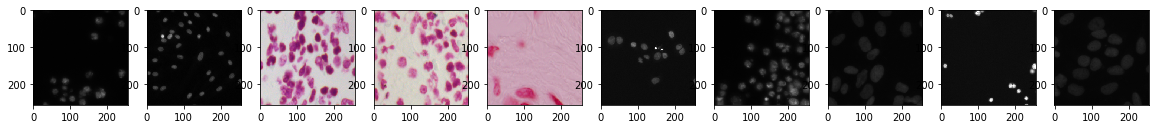

In [108]:
fig, axs = plt.subplots(1, 10, figsize=(20,20))
for i in range(10):
    axs[i].imshow(X_train[i])

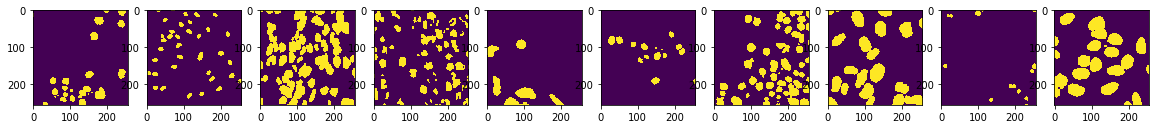

In [110]:
fig, axs = plt.subplots(1, 10, figsize=(20,20))
for i in range(10):
    axs[i].imshow(np.squeeze(Y_train[i]))

### Define IoU metric

In [122]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

## Build the model

In [128]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import tensorflow as tf

inputs = Input((img_size, img_size, 3))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 256, 256, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_60 (Conv2D)              (None, 256, 256, 16) 448         lambda_4[0][0]                   
__________________________________________________________________________________________________
dropout_28 (Dropout)            (None, 256, 256, 16) 0           conv2d_60[0][0]                  
__________________________________________________________________________________________________
conv2d_61 

## Train the model

In [ ]:
batch_size = 50
epochs = 5
num_classes = 10

model.fit(X_train, Y_train, batch_size=batch_size,epochs=epochs,verbose=1)

Epoch 1/5


### Trim

In [5]:
%matplotlib inline
from keras.datasets import fashion_mnist
(train_X,train_Y), (test_X,test_Y) = fashion_mnist.load_data()

In [2]:
import numpy as np
from keras.utils import to_categorical
import matplotlib.pyplot as plt
%matplotlib inline

print('Training data shape : ', train_X.shape, train_Y.shape)

print('Testing data shape : ', test_X.shape, test_Y.shape)

Training data shape :  (60000, 28, 28) (60000,)
Testing data shape :  (10000, 28, 28) (10000,)


In [3]:
classes = np.unique(train_Y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  10
Output classes :  [0 1 2 3 4 5 6 7 8 9]


Text(0.5,1,'Ground Truth : 9')

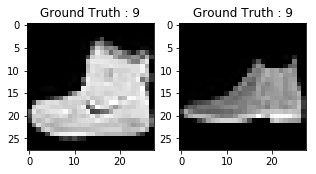

In [7]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
plt.imshow(train_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(train_Y[0]))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(test_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(test_Y[0]))

In [8]:
train_X = train_X.reshape(-1, 28,28, 1)
test_X = test_X.reshape(-1, 28,28, 1)
train_X.shape, test_X.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [9]:
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X / 255.
test_X = test_X / 255.